## Решение задачи предсказания результатов экзаменов учеников по математике

*Импорт библиотек*

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

### Этапы решения
* Первичная обработку данных. 
* Анализ распределения признака для числовых переменных, устранение выбросов.
* Оценика количества уникальных значений для номинативных переменных.
* Преобразование данных
* Корреляционный анализ количественных переменных
* Отбор не коррелирующих переменных
* Анализ номинативных переменных и устранение тех, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
* Формулирование выводов относительно качества данных и тех переменных, которые вы будут использованы в дальнейшем для построения модели.



### Функции для обработки данных

In [129]:
def test_col(col):
    '''
        Проверка колонки на выбросы
    '''
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    col.loc[col.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (col.min(), col.max()), label = 'IQR')
    plt.legend()


def filter_col(df, col):
    '''
        Удаление выбросв из датасета
    '''
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)
    
    return df.loc[col.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]    


### Первичная обработка данных.
*Вывод первых 10 строк таблицы*

In [130]:
stud = stud.rename(columns = {'studytime, granular' : 'studytime_granular'})
display(stud.head(10))

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0   at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0   at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0    health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0     other    other   
5     GP   M   16       U     LE3       T   4.0   3.0  services    other   
6     GP   M   16     NaN     LE3       T   2.0   2.0     other    other   
7     GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
8     GP   M   15       U     LE3       A   3.0   2.0  services    other   
9     GP   M   15       U     NaN     NaN   3.0   4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime_granular higher internet romantic  famrel  \
0         no     yes                -6.0    yes      NaN       no     4.0   
1         no      no                -6.0    yes      yes       no     5.0   
2         no     yes                -6.0    yes      yes      NaN     4.0   
3        yes     yes                -9.0    yes      yes      yes     3.0   
4         no     yes                -6.0    yes       no       no     4.0   
5        yes     yes                -6.0    yes      yes       no     5.0   
6         no     yes                -6.0    yes      yes       no     4.0   
7         no     yes                -6.0    yes       no       no     4.0   
8         no     yes                -6.0    yes      yes       no     NaN   
9        yes     yes                -6.0    yes      yes       no     5.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0  
5       4.0    2.0     5.0      10.0   75.0  
6       4.0    4.0     3.0       0.0   55.0  
7       1.0    4.0     1.0       6.0   30.0  
8       2.0    2.0     1.0       0.0   95.0  
9       5.0    1.0     5.0       0.0   75.0

*Переименование стобца и вывод информации о таблице*

In [131]:
stud = stud.rename(columns = {'studytime, granular' : 'studytime_granular'})
stud.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

Датасет содержит 30 полей из них числовых столбцов 13 строковых 17. Поле `age` являтся целочисленным.

 

### Анализ распределения признака для числовых переменных, устранение выбросов.
 * age
 * Medu
 * Fedu
 * traveltime
 * studytime
 * failures
 * studytime_granular
 * famrel
 * freetime
 * goout 
 * health
 * absences
 * score

## score
Оценка. Этот параметр будет предсказывать будующая модель.

In [132]:
stud.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

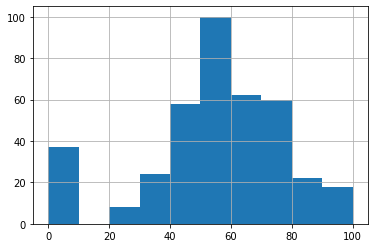

In [133]:
stud.score.hist()
stud.score.describe()

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


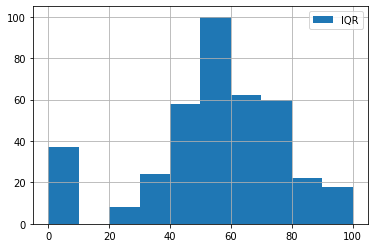

In [134]:
test_col(stud.score)

Выводы по `score`:
* Использовалась 100 бальная шакла оценивания
* Выбросов нет

## age
Возраст


In [135]:
stud.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

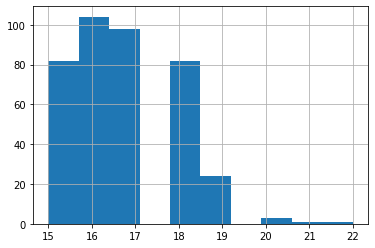

In [136]:
stud.age.hist()
stud.age.describe()

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


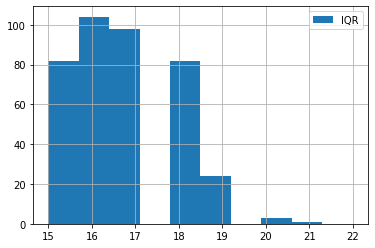

In [137]:
test_col(stud.age)    


Вывод:
* Большинство студентов моложе 19 лет
* В данных нет выбросов

display(stud.age.value_counts())

## Medu
Образование матери

In [138]:
stud.Medu.value_counts()

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64

Пустых значений и ошибок данных нет

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

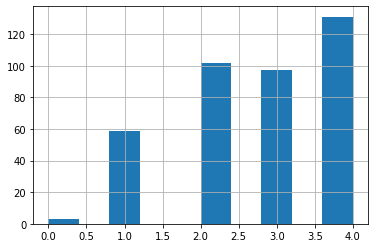

In [139]:
stud.Medu.hist()
stud.Medu.describe()


25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


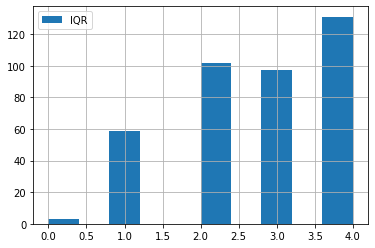

In [140]:
test_col(stud.Medu)

Вывод:
* Большинство матерей имеют образование 5-9 классов и выше
* Выбросов нет

## Fedu
образование отца    

In [141]:
stud.Fedu.value_counts()


2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

Есть одно ошибочное значение 40. Предположим что это опечатка, и исправим на 4  

In [142]:
stud.Fedu = stud.Fedu.astype(float).apply(lambda x: 4 if x == 40 else x)
stud.Fedu.value_counts()

2.0    106
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64

count    371.000000
mean       2.517520
std        1.088808
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

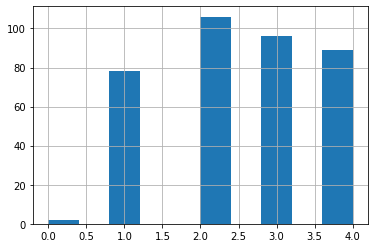

In [143]:
stud.Fedu.hist()
stud.Fedu.describe()

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


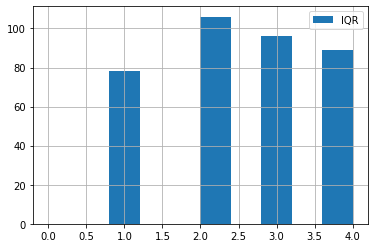

In [144]:
test_col(stud.Fedu)

Выбросы есть. 25-прецентиль равен 2. Удалим Выбросы из датасета.

count    369.000000
mean       2.531165
std        1.075785
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

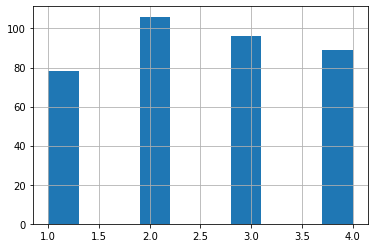

In [145]:
stud = filter_col(stud, stud.Fedu)
stud.Fedu.hist()
stud.Fedu.describe()

Вывод:
* Уровень образования отцов распределен равномерно после удаления выбросов

# traveltime
Время в пути до школы

In [146]:
stud.traveltime.value_counts()

1.0    225
2.0     90
3.0     22
4.0      7
Name: traveltime, dtype: int64

Ошибок и пустых значений нет

count    344.000000
mean       1.450581
std        0.706405
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

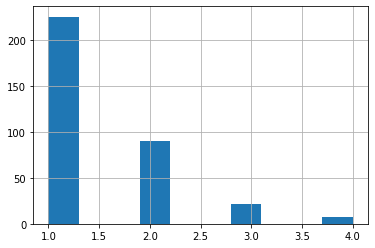

In [147]:
stud.traveltime.hist()
stud.traveltime.describe()

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


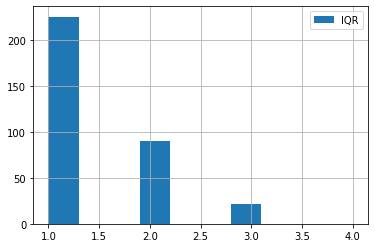

In [148]:
test_col(stud.traveltime)

Большинство детей тратят мало времени по дороге в школу. Удалим тех кто добирается более 10 часов.

count    337.000000
mean       1.397626
std        0.609249
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: traveltime, dtype: float64

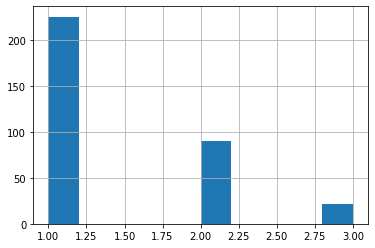

In [149]:
stud = filter_col(stud, stud.traveltime)
stud.traveltime.hist()
stud.traveltime.describe()

Вывод:
* Данные распределены неравномерно
* Большинство детей тратят < 15 мин на дорогу в школу

## studytime
Время на учебу помимо школы в неделю

In [150]:
stud.studytime.value_counts()

2.0    166
1.0     89
3.0     54
4.0     22
Name: studytime, dtype: int64

Пустых значений и ошибок в данных нет

count    331.000000
mean       2.027190
std        0.836217
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

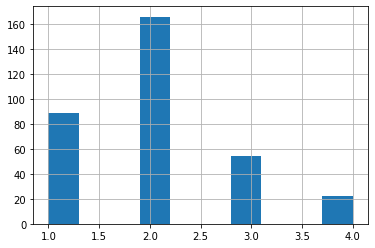

In [151]:
stud.studytime.hist()
stud.studytime.describe()

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


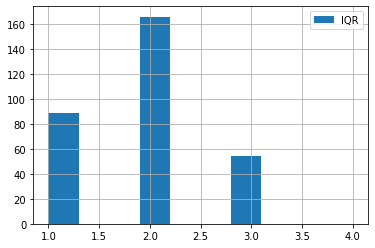

In [152]:
test_col(stud.studytime)

75й процентиль равен 2. Обнаружены выбросы. Удалим их.

count    309.000000
mean       1.886731
std        0.671874
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: studytime, dtype: float64

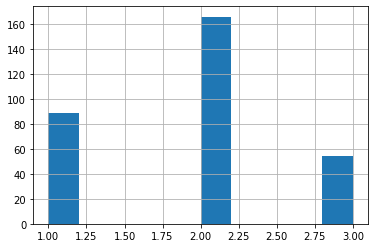

In [153]:
stud = filter_col(stud, stud.studytime)
stud.studytime.hist()
stud.studytime.describe()

Вывод:
* Обнаружены выбросы
* Большинтво детей тратит на учебу помимо школы 2 часа в день

## failures
количество внеучебынх неудач

In [154]:
stud.failures.value_counts()

0.0    231
1.0     41
2.0     12
3.0     12
Name: failures, dtype: int64

count    296.000000
mean       0.341216
std        0.742276
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

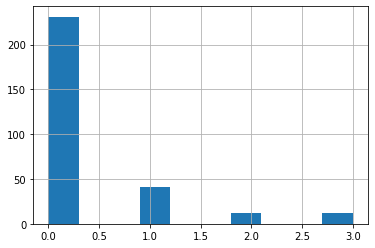

In [155]:
stud.failures.hist()
stud.failures.describe()

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


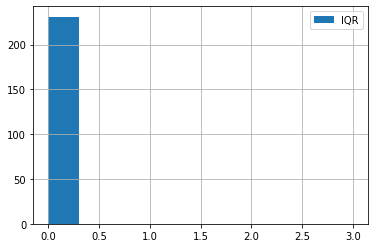

In [156]:
test_col(stud.failures)

Данные крайне неравномерно распределены. Удалим колонку из датасета.

In [157]:
stud.drop(['failures'], inplace = True, axis = 1)

## studytime_granular
Детализация времени обучения


In [158]:
stud.studytime_granular.value_counts()

-6.0    166
-3.0     89
-9.0     54
Name: studytime_granular, dtype: int64

count    309.000000
mean      -5.660194
std        2.015621
min       -9.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

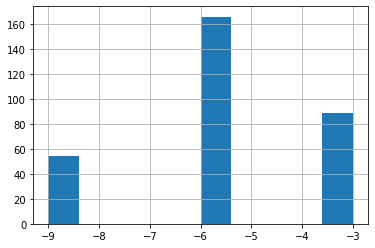

In [159]:
stud.studytime_granular.hist()
stud.studytime_granular.describe()

25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].


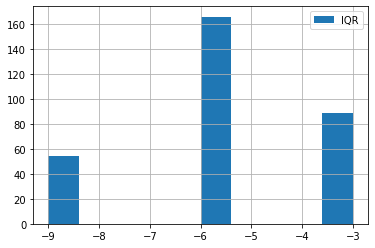

In [160]:
test_col(stud.studytime_granular)

Вывод:
* Пустых и ошибочных значений нет
* Выбросов не обнаружено

## famrel
Семейные отношения



In [161]:
stud.famrel.value_counts()

 4.0    146
 5.0     75
 3.0     48
 2.0     14
 1.0      4
-1.0      1
Name: famrel, dtype: int64

Обнаружено ошибочное значение -1. Исправим на 1

In [162]:
stud.famrel = stud.famrel.astype(float).apply(lambda x: 1 if x == -1 else x)
stud.famrel.value_counts()

4.0    146
5.0     75
3.0     48
2.0     14
1.0      5
Name: famrel, dtype: int64

count    288.000000
mean       3.944444
std        0.881698
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

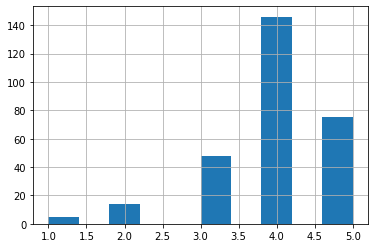

In [163]:
stud.famrel.hist()
stud.famrel.describe()

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


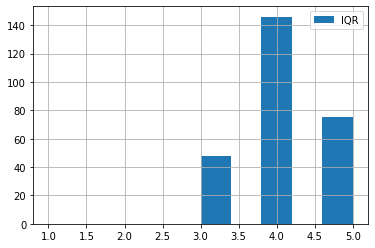

In [164]:
test_col(stud.famrel)

In [165]:
stud = filter_col(stud, stud.famrel)

<AxesSubplot:>

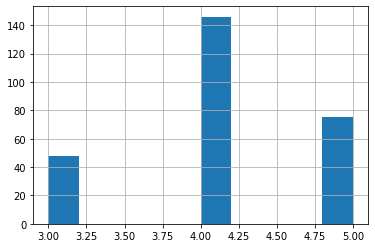

In [166]:
stud.famrel.hist()

Вывод:
* У большинства детей хорошие отношения в смье
* Обнаружены и удалены выбросы

## freetime
Свободное время после школы

In [167]:
stud.freetime.value_counts()

3.0    107
4.0     78
2.0     42
5.0     25
1.0     10
Name: freetime, dtype: int64

count    262.000000
mean       3.251908
std        0.965644
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

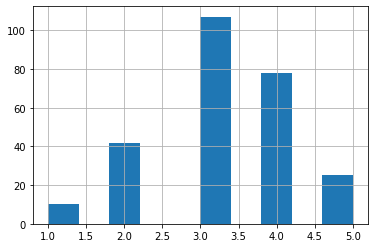

In [168]:
stud.freetime.hist()
stud.freetime.describe()

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


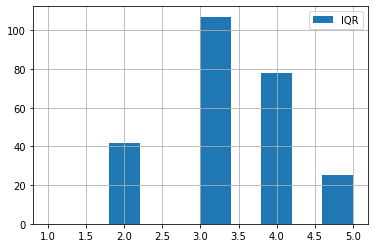

In [169]:
test_col(stud.freetime)

<AxesSubplot:>

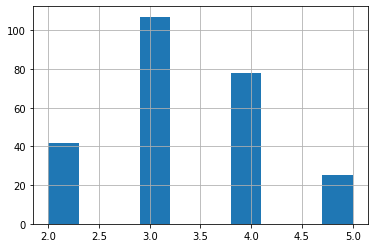

In [170]:
stud = filter_col(stud, stud.freetime)
stud.freetime.hist()

Вывод:
* Данные корректны и не требуют исправлений
* Большинство детей имеют средний показатель свободного времени после школы
* Обнаружены и удалены выбросы

## goout
Проведение времени с друзьями

In [171]:
stud.goout.value_counts()

3.0    88
2.0    58
4.0    58
5.0    29
1.0    13
Name: goout, dtype: int64

count    246.000000
mean       3.130081
std        1.068735
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

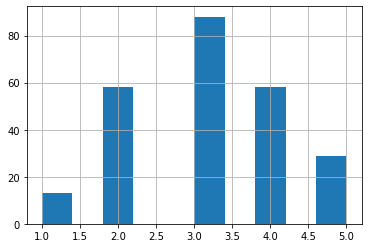

In [172]:
stud.goout.hist()
stud.goout.describe()

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


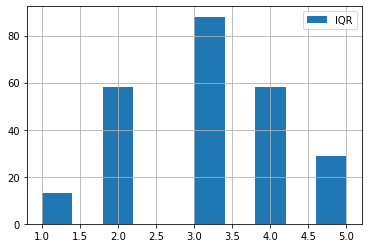

In [173]:
test_col(stud.goout)

Вывод:
* Данные корректны
* Выбросов нет
* Бльшинство детей имеют средний показатель по времени для общения с друзьями

## health
Текущее состояние здоровья


In [174]:
stud.health.value_counts()

5.0    85
3.0    58
4.0    41
2.0    32
1.0    29
Name: health, dtype: int64

count    245.000000
mean       3.493878
std        1.386765
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

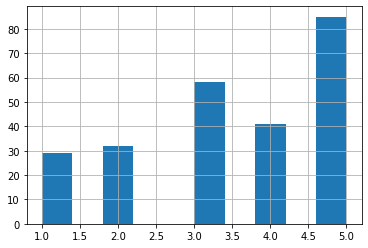

In [175]:
stud.health.hist()
stud.health.describe()


25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


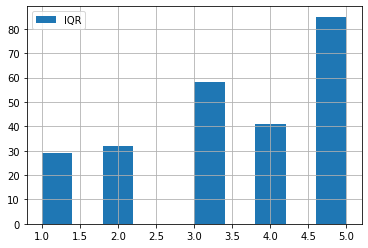

In [176]:
test_col(stud.health)

Вывод:
* Данные корректны
* Выбросов нет
* Бльшинство детей имеют средний хороший показатель здровья

## absences
Количество пропущенных занаятий

In [177]:
stud.absences.value_counts()

0.0      71
2.0      40
4.0      39
6.0      16
8.0      15
10.0      9
12.0      8
16.0      7
3.0       7
14.0      4
7.0       3
22.0      3
5.0       2
20.0      2
9.0       2
18.0      2
25.0      1
26.0      1
212.0     1
56.0      1
24.0      1
13.0      1
15.0      1
1.0       1
38.0      1
23.0      1
11.0      1
17.0      1
28.0      1
Name: absences, dtype: int64

count    243.000000
mean       6.201646
std       14.999052
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      212.000000
Name: absences, dtype: float64

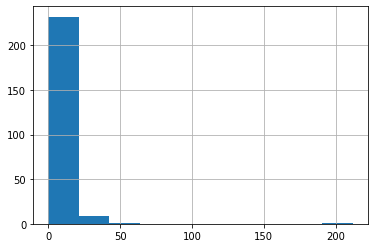

In [178]:
stud.absences.hist()
stud.absences.describe()

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


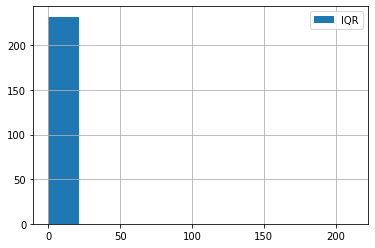

In [179]:
test_col(stud.absences)

Прогульшиков мало, удалим их из списка

<AxesSubplot:>

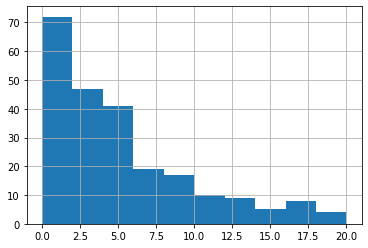

In [180]:
stud = filter_col(stud, stud.absences)
stud.absences.hist()

Вывод:
* Данные корректын
* Обнаружены и удалены выбросы
* Явно видна тенденция к снижению количества пропусков занятий

## Оценка количества уникальных значений для номинативных переменных.

In [181]:
fields = ['school', 'sex', 'address', 'famsize', 'Pstatus',
    'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
    'famsup', 'paid', 'activities', 'nursery', 'higher',
    'internet','romantic']
for field in fields: 
    display(stud[field].value_counts())

GP    202
MS     30
Name: school, dtype: int64

F    118
M    114
Name: sex, dtype: int64

U    176
R     47
Name: address, dtype: int64

GT3    153
LE3     64
Name: famsize, dtype: int64

T    192
A     18
Name: Pstatus, dtype: int64

other       77
services    59
at_home     34
teacher     33
health      19
Name: Mjob, dtype: int64

other       117
services     64
teacher      16
at_home      12
health        6
Name: Fjob, dtype: int64

course        81
home          63
reputation    55
other         23
Name: reason, dtype: int64

mother    142
father     50
other      17
Name: guardian, dtype: int64

no     200
yes     26
Name: schoolsup, dtype: int64

yes    124
no      87
Name: famsup, dtype: int64

no     121
yes     87
Name: paid, dtype: int64

yes    117
no     106
Name: activities, dtype: int64

yes    167
no      50
Name: nursery, dtype: int64

yes    207
no      13
Name: higher, dtype: int64

yes    178
no      30
Name: internet, dtype: int64

no     145
yes     71
Name: romantic, dtype: int64

Вывод:
* Данные корректны, пропусков и ошибочных значений нет
* Количестов уникальных значенй лежит в диапазоне от 2 до 5

## Корреляционный анализ количественных переменных


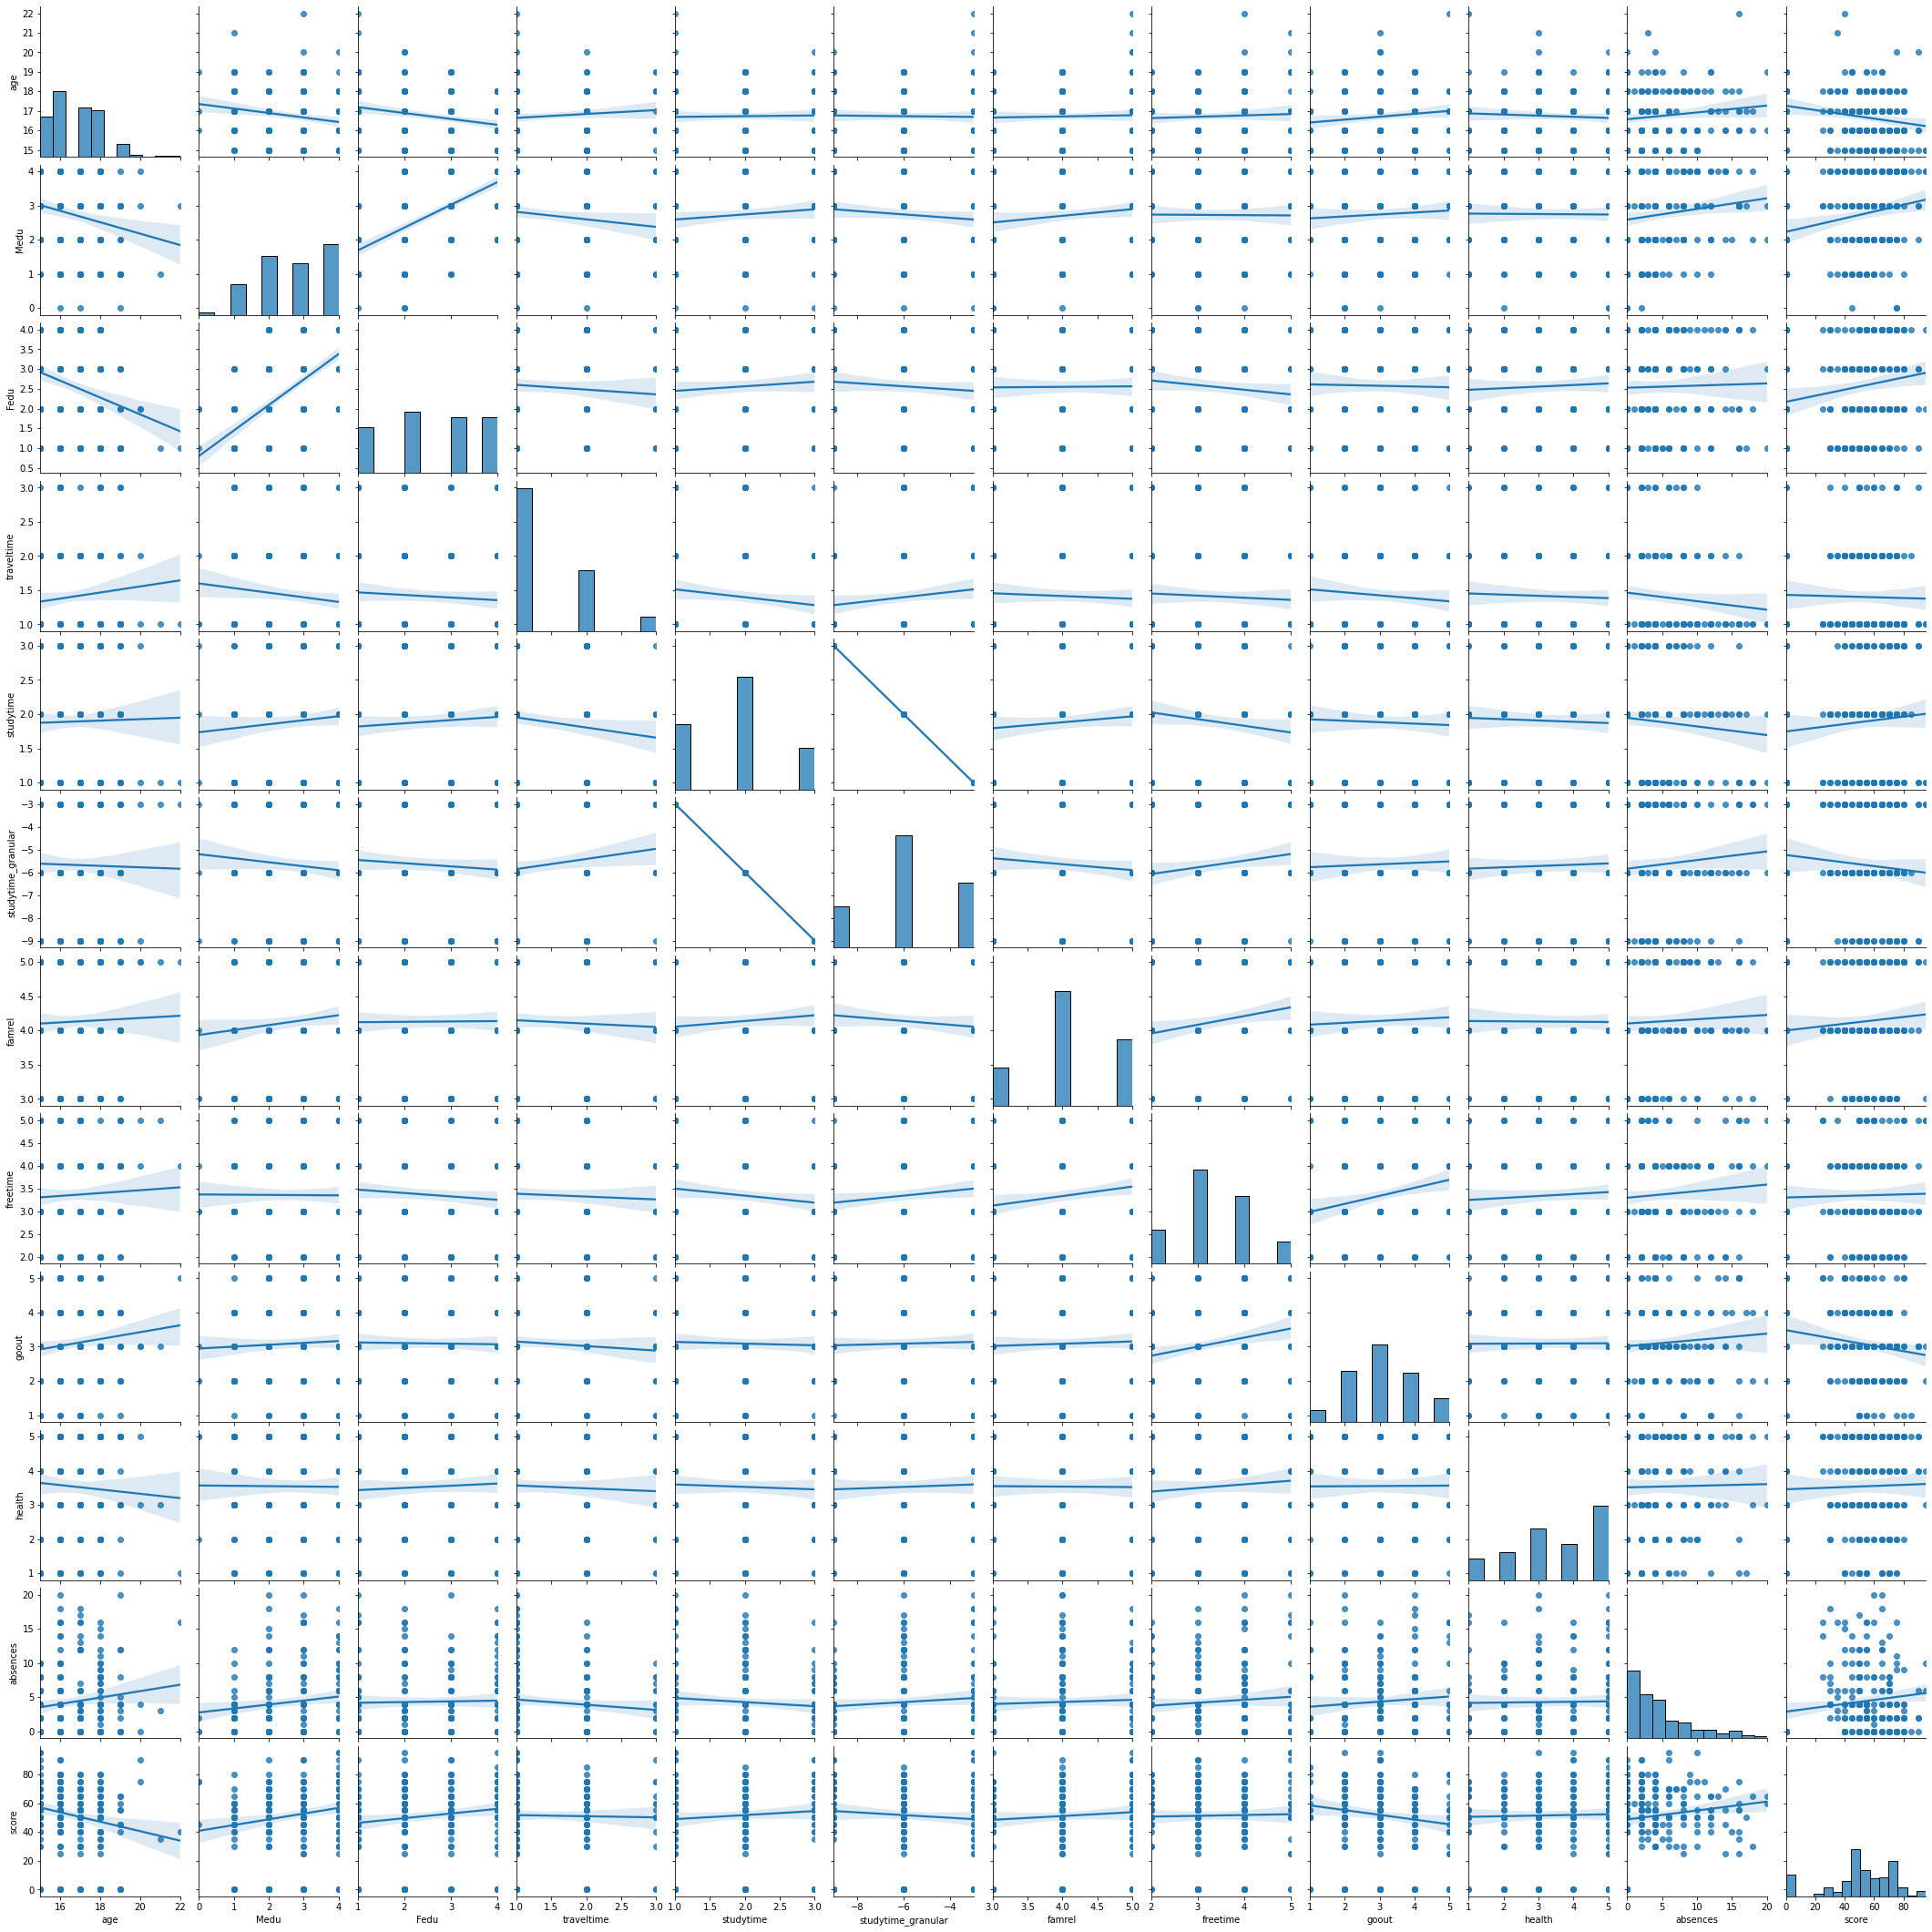

In [182]:
sns.pairplot(stud, kind = 'reg')

In [183]:
stud.corr()

age      Medu      Fedu  traveltime  studytime  \
age                 1.000000 -0.195884 -0.253781    0.094101   0.019826   
Medu               -0.195884  1.000000  0.655270   -0.121932   0.093708   
Fedu               -0.253781  0.655270  1.000000   -0.067878   0.073670   
traveltime          0.094101 -0.121932 -0.067878    1.000000  -0.130964   
studytime           0.019826  0.093708  0.073670   -0.130964   1.000000   
studytime_granular -0.019826 -0.093708 -0.073670    0.130964  -1.000000   
famrel              0.030915  0.118717  0.008503   -0.044823   0.085336   
freetime            0.046882 -0.006597 -0.093393   -0.044143  -0.122481   
goout               0.122305  0.055918 -0.017869   -0.076241  -0.032348   
health             -0.060734 -0.008225  0.050836   -0.037900  -0.036552   
absences            0.127890  0.134541  0.023665   -0.097071  -0.087213   
score              -0.189889  0.198487  0.158255   -0.021422   0.087500   

                    studytime_granular    famrel  freetime     goout  \
age                          -0.019826  0.030915  0.046882  0.122305   
Medu                         -0.093708  0.118717 -0.006597  0.055918   
Fedu                         -0.073670  0.008503 -0.093393 -0.017869   
traveltime                    0.130964 -0.044823 -0.044143 -0.076241   
studytime                    -1.000000  0.085336 -0.122481 -0.032348   
studytime_granular            1.000000 -0.085336  0.122481  0.032348   
famrel                       -0.085336  1.000000  0.163110  0.042315   
freetime                      0.122481  0.163110  1.000000  0.216340   
goout                         0.032348  0.042315  0.216340  1.000000   
health                        0.036552 -0.007043  0.067690  0.004456   
absences                      0.087213  0.043640  0.079384  0.082605   
score                        -0.087500  0.080892  0.022024 -0.159127   

                      health  absences     score  
age                -0.060734  0.127890 -0.189889  
Medu               -0.008225  0.134541  0.198487  
Fedu                0.050836  0.023665  0.158255  
traveltime         -0.037900 -0.097071 -0.021422  
studytime          -0.036552 -0.087213  0.087500  
studytime_granular  0.036552  0.087213 -0.087500  
famrel             -0.007043  0.043640  0.080892  
freetime            0.067690  0.079384  0.022024  
goout               0.004456  0.082605 -0.159127  
health              1.000000  0.016372  0.026595  
absences            0.016372  1.000000  0.133087  
score               0.026595  0.133087  1.000000

Слабо коррелируют переменные показателя здоровья, семейных отношений, времени пути в школу.


## Анализ номинативных переменных

In [184]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud.loc[stud.loc[:, column].isin(stud.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

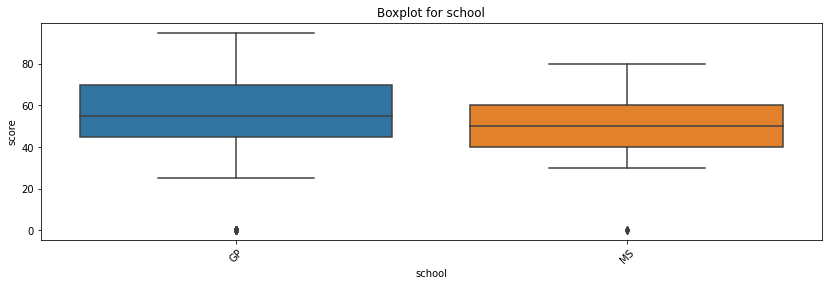

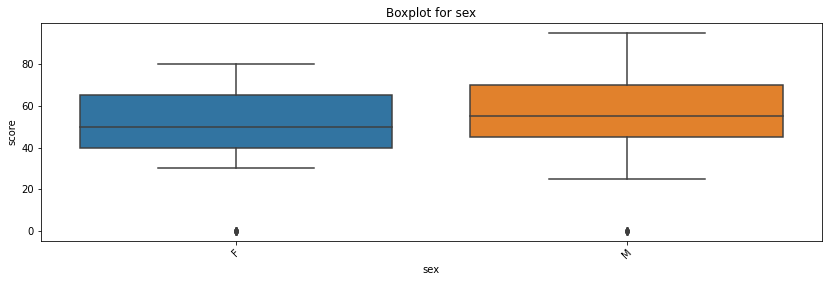

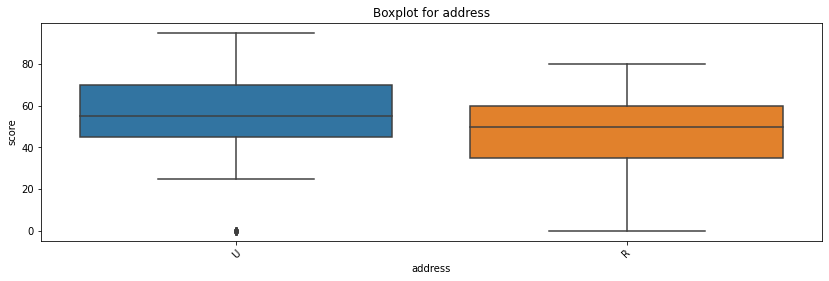

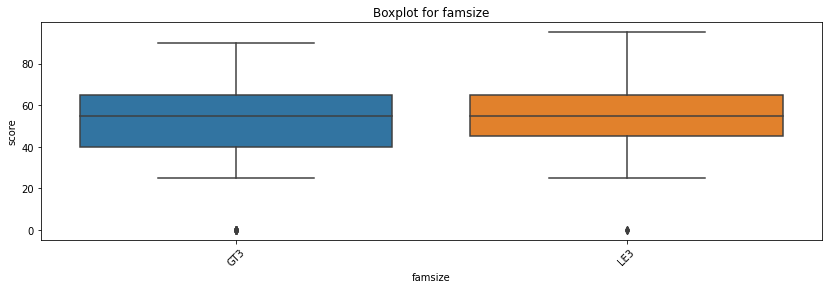

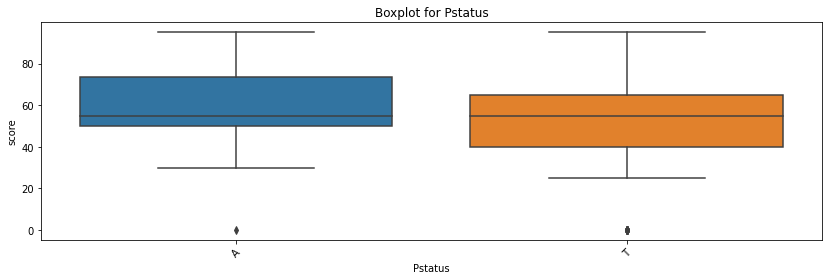

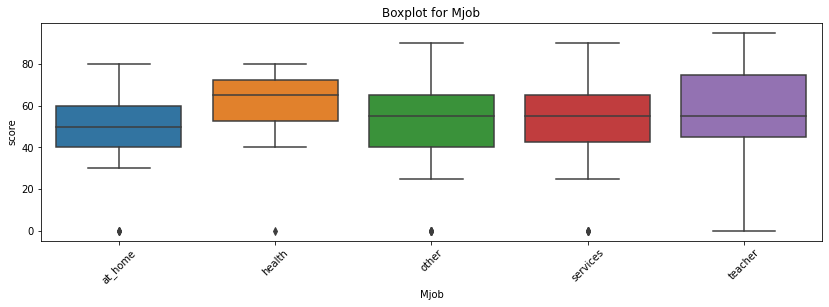

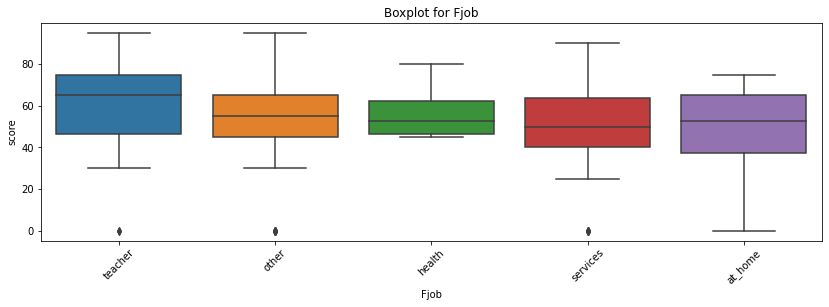

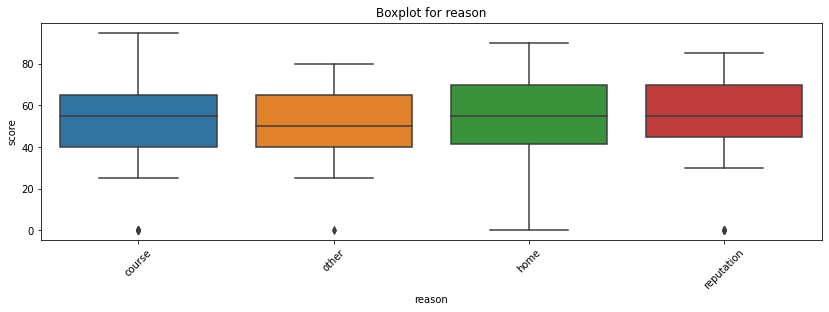

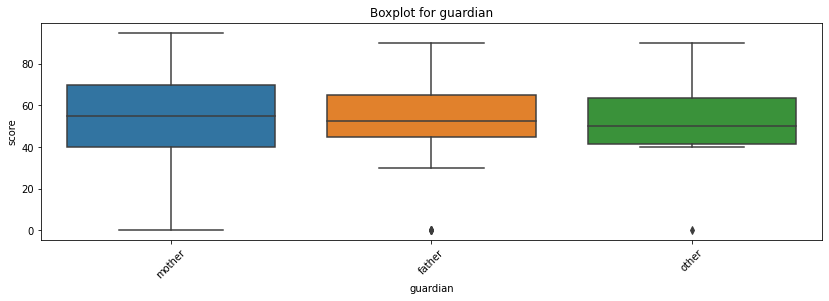

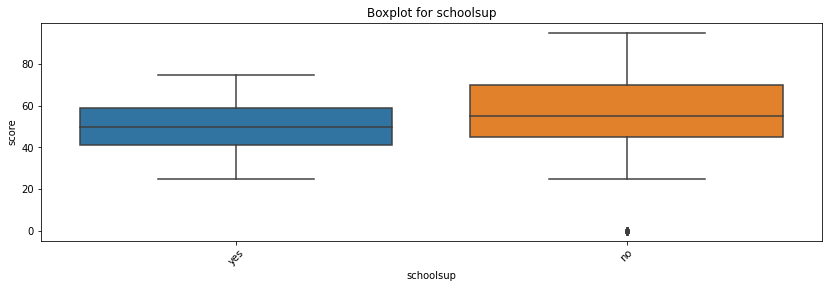

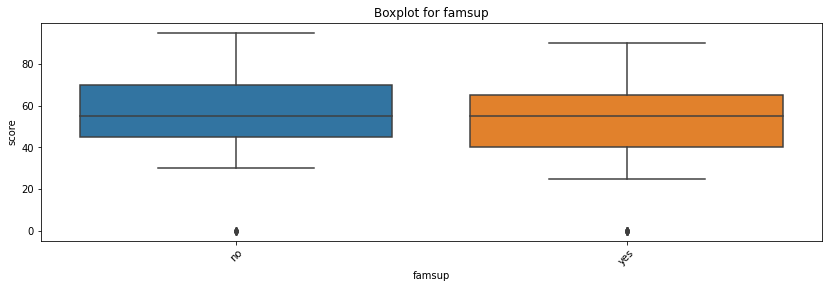

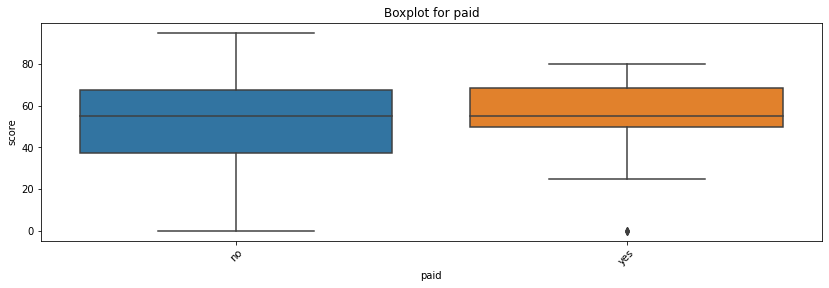

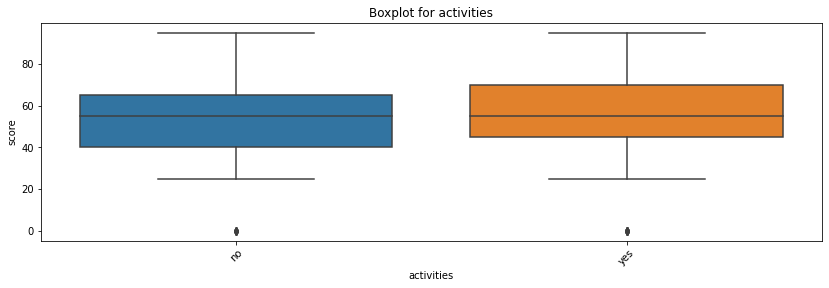

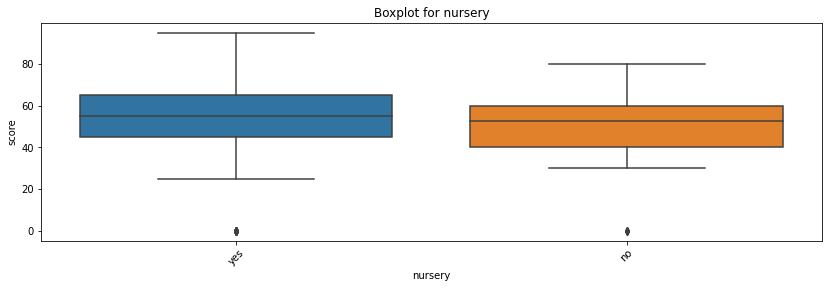

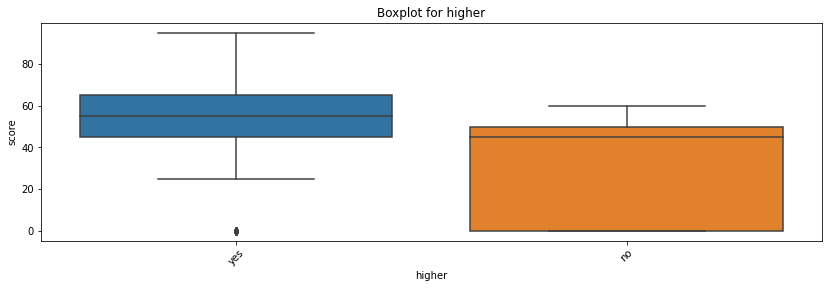

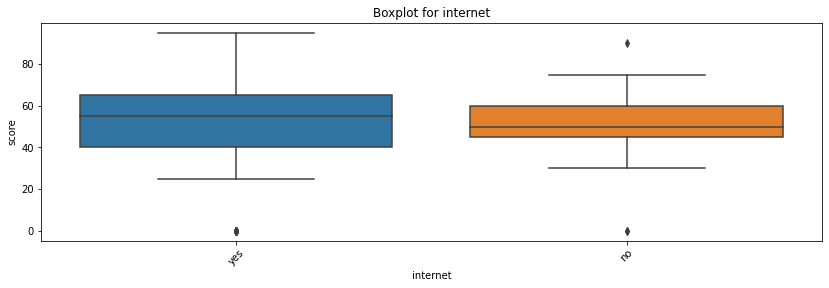

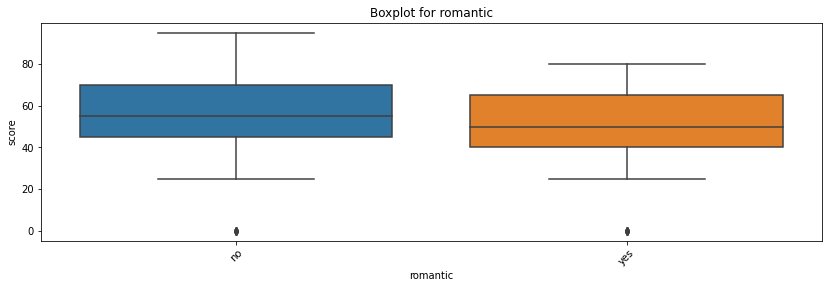

In [185]:
for col in fields:
    get_boxplot(col)

Вывод. 
Половина параметров влияют на уровень оценки. Наибольшее положительное влияние оказывает желение получить высшее образование. 
Слабое влияние оказывают параметы:
* famsize
* Pstatus
* Mjob
* Fjob
* reason
* famsup
* paid

Cледует отметь связь сниженя оценки при наличии романтических отношенй и отсутсвие при наличии платных занятий.

## Тест Стьюдента

In [188]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [189]:
for col in fields:
    get_stat_dif(col)

In [190]:
stud_for_model = stud.loc[:, ['age', 'Medu', 'Fedu', 'studytime', 'studytime_granular', 'famrel', 'goout', 'absences', 'score', 'school', 'sex', 'address', 'romantic', 'internet']]
stud_for_model.head()

age  Medu  Fedu  studytime  studytime_granular  famrel  goout  absences  \
0   18   4.0   4.0        2.0                -6.0     4.0    4.0       6.0   
1   17   1.0   1.0        2.0                -6.0     5.0    3.0       4.0   
2   15   1.0   1.0        2.0                -6.0     4.0    2.0      10.0   
3   15   4.0   2.0        3.0                -9.0     3.0    2.0       2.0   
4   16   3.0   3.0        2.0                -6.0     4.0    2.0       4.0   

   score school sex address romantic internet  
0   30.0     GP   F       U       no      NaN  
1   30.0     GP   F       U       no      yes  
2   50.0     GP   F       U      NaN      yes  
3   75.0     GP   F       U      yes      yes  
4   50.0     GP   F       U       no       no

## Выводы

* В данных не найдено пустых значений.
* Часть данных (несколько записей) принята за ошибочные и испрвлена.
* При обнаружении выбросов данные удалялись.

Слабо коррелируют переменные показателя здоровья, семейных отношений, времени пути в школу. 
